In [4]:
# statistical analysis of temperature data, QuantPy on YouTube
# heating degree days (HDD), cooling degree days (CDD) "average" Temperature = Tmax + Tmin / 2

# KANSAS CITY ?, 1889-01-01 to 12/31/1933
# KANSAS CITY DOWNTOWN AIRPORT, 1/1/1934 to 9/30/1972
# KANSAS CITY INTL AIRPORT, 10/1/1972 to 12/31/2021

# Tmax, Tmin, Precipitation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

kansas_city = pd.read_csv("data/USW00003947.csv")

### Check for missing data

In [5]:
### Checking for missing max and min temperatures #was 63 and 56 with 54 misaligned; restricted to KCI there are 0
max_temp = kansas_city[["Date","tmax"]]
min_temp = kansas_city[["Date","tmin"]]
print(max_temp.isnull().value_counts())
print(min_temp.isnull().value_counts())

count = 0
for mx, mn in zip(np.where(max_temp.isnull())[0], np.where(min_temp.isnull())[0]):
    if mx != mn:
        count += 1
print('\nNumber of misaligned null values equals', count)
###

Date   tmax 
False  False    48514
       True        63
Name: count, dtype: int64
Date   tmin 
False  False    48521
       True        56
Name: count, dtype: int64

Number of misaligned null values equals 54


### Calculate average temps and drop missing values

In [6]:
kansas_city["Date"] = pd.to_datetime(kansas_city["Date"]) #Thanks skbrimmer!
kansas_city.set_index("Date", inplace=True)
kc_temps = kansas_city[["tmax", "tmin"]]

def avg_temp(row):
    return (row.tmax+row.tmin)/2

kc_temps["Tavg"] = kc_temps.apply(avg_temp,axis=1)
#drop na values here
kc_temps = kc_temps.dropna()
print(kc_temps)
print(kc_temps.describe())

            tmax  tmin   Tavg
Date                         
1889-01-01  44.0  19.0  31.50
1889-01-02  48.0  28.0  38.00
1889-01-03  52.0  33.0  42.50
1889-01-04  42.0  31.0  36.50
1889-01-05  30.0  25.0  27.50
...          ...   ...    ...
2021-12-27  64.0  39.0  51.50
2021-12-28  57.0  23.2  40.10
2021-12-29  33.1  19.2  26.15
2021-12-30  44.1  28.2  36.15
2021-12-31  54.0  30.9  42.45

[48461 rows x 3 columns]
               tmax          tmin          Tavg
count  48461.000000  48461.000000  48461.000000
mean      64.897825     45.805518     55.351671
std       21.064497     19.604851     20.031139
min       -8.000000    -23.000000    -15.500000
25%       49.000000     31.000000     40.000000
50%       68.000000     47.000000     57.450000
75%       82.000000     63.000000     72.500000
max      113.000000     87.000000     99.500000


C:\Users\erics\AppData\Local\Temp\ipykernel_7556\1240425566.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kc_temps["Tavg"] = kc_temps.apply(avg_temp,axis=1)


### Flag winter and summer periods

In [7]:
# why deep copy? does it matter if the same values are referenced, and why do we need completely new bits?
kc_temps_season = kc_temps.copy(deep=True)
kc_temps_season["month"] = kc_temps_season.index.month
mask = (kc_temps_season["month"] >= 4) & (kc_temps_season["month"] <= 9)
kc_temps_season["summer"] = np.where(mask,1,0)
kc_temps_season["winter"] = np.where(kc_temps_season["summer"] != 1,1,0)
print(kc_temps_season)

            tmax  tmin   Tavg  month  summer  winter
Date                                                
1889-01-01  44.0  19.0  31.50      1       0       1
1889-01-02  48.0  28.0  38.00      1       0       1
1889-01-03  52.0  33.0  42.50      1       0       1
1889-01-04  42.0  31.0  36.50      1       0       1
1889-01-05  30.0  25.0  27.50      1       0       1
...          ...   ...    ...    ...     ...     ...
2021-12-27  64.0  39.0  51.50     12       0       1
2021-12-28  57.0  23.2  40.10     12       0       1
2021-12-29  33.1  19.2  26.15     12       0       1
2021-12-30  44.1  28.2  36.15     12       0       1
2021-12-31  54.0  30.9  42.45     12       0       1

[48461 rows x 6 columns]


### Visually explore data

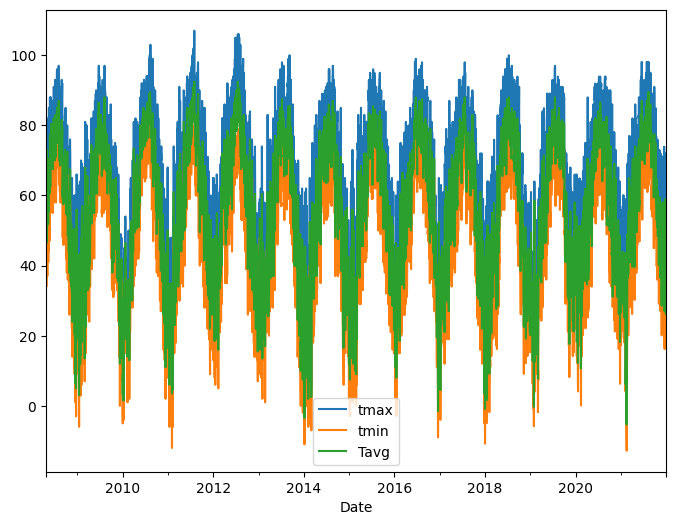

In [8]:
kc_temps[-5000:].plot(figsize=(8,6))
plt.show()

### Distributions

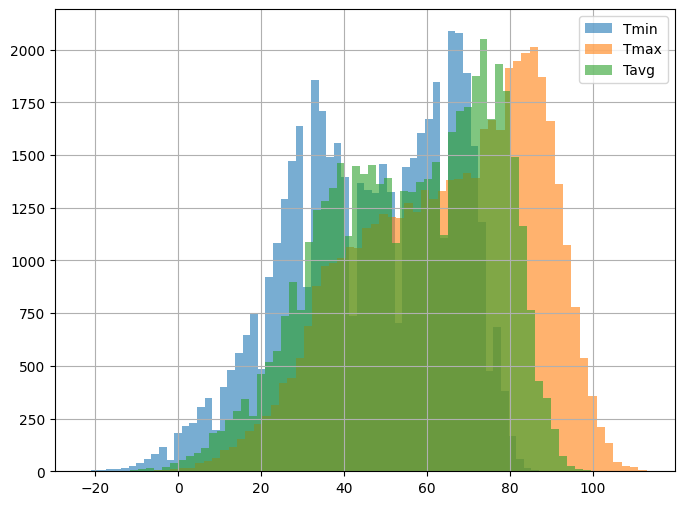

In [9]:
plt.figure(figsize=(8,6))
kc_temps.tmin.hist(bins=60, alpha=0.6, label="Tmin")
kc_temps.tmax.hist(bins=60, alpha=0.6, label="Tmax")
kc_temps["Tavg"].hist(bins=60, alpha=0.6, label="Tavg")
plt.legend()
plt.show()

### Summer and Winter

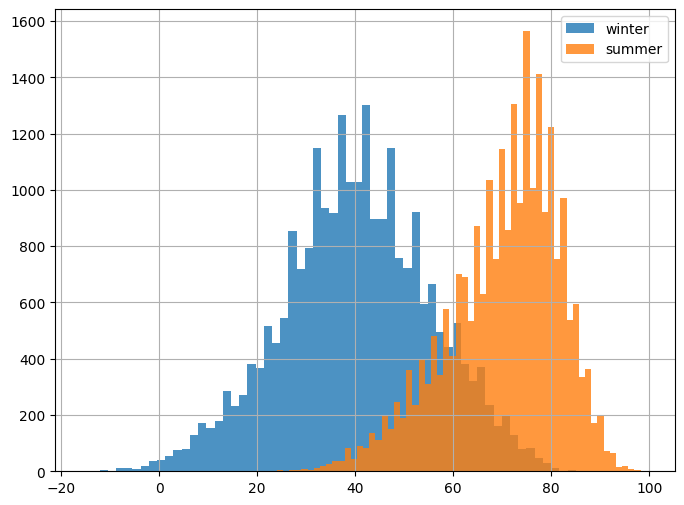

In [10]:
plt.figure(figsize=(8,6))
kc_temps_season[kc_temps_season["winter"] == 1]["Tavg"].hist(bins=60, alpha=0.8, label="winter")
kc_temps_season[kc_temps_season["summer"] == 1]["Tavg"].hist(bins=60, alpha=0.8, label="summer")
plt.legend()
plt.show()

### Investigate temperature records

In [11]:
# resample by month start, calculate mins and maxes for tmax, tmin and Tavg
date_list = kc_temps.index.tolist()
mth_kc_temps = pd.DataFrame(data=date_list, index=date_list).resample("MS")[0].agg([min,max])
mth_kc_temps["month"] = mth_kc_temps.index.month
def min_max_temps(row):
    stats = kc_temps[(kc_temps.index >= row["min"]) & (kc_temps.index <= row["max"])].agg([min, max])
    row["tmax_max"] = stats.loc["max", "tmax"]
    row["tmax_min"] = stats.loc["min", "tmax"]
    row["tmin_max"] = stats.loc["max", "tmin"]
    row["tmin_min"] = stats.loc["min", "tmin"]
    row["Tavg_max"] = stats.loc["max", "Tavg"]
    row["Tavg_min"] = stats.loc["min", "Tavg"]
    return row

mth_kc_temps = mth_kc_temps.apply(min_max_temps,axis=1)
mth_kc_temps

,min,max,month,tmax_max,tmax_min,tmin_max,tmin_min,Tavg_max,Tavg_min
1889-01-01,1889-01-01,1889-01-31,1,52.0,20.0,33.0,4.0,42.50,14.50
1889-02-01,1889-02-01,1889-02-28,2,65.0,10.0,46.0,-4.0,55.50,3.00
1889-03-01,1889-03-01,1889-03-31,3,71.0,35.0,49.0,22.0,60.00,31.00
1889-04-01,1889-04-01,1889-04-30,4,87.0,48.0,55.0,33.0,67.00,46.00
1889-05-01,1889-05-01,1889-05-31,5,85.0,58.0,70.0,39.0,76.00,49.00
...,...,...,...,...,...,...,...,...,...
2021-08-01,2021-08-01,2021-08-31,8,98.1,82.9,81.0,61.0,89.55,72.50
2021-09-01,2021-09-01,2021-09-30,9,91.0,72.0,71.1,45.0,78.00,59.45
2021-10-01,2021-10-01,2021-10-31,10,84.9,50.0,64.9,36.0,74.90,48.45
2021-11-01,2021-11-01,2021-11-30,11,73.0,37.0,50.0,20.1,59.50,28.55


### Extremes on Record

In [12]:
grouped_mths_kc = mth_kc_temps.groupby(mth_kc_temps.month)[["tmax_max", "tmax_min", "tmin_max", "tmin_min", "Tavg_max", "Tavg_min"]].agg([min, max])
grouped_mths_kc['months'] = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
grouped_mths_kc = grouped_mths_kc.set_index('months')
print(grouped_mths_kc[[("tmax_max", "max"),("tmin_min", "min"),("tmax_min", "min"),("tmin_max", "max")]])

       tmax_max tmin_min tmax_min tmin_max
            max      min      min      max
months                                    
Jan        75.0    -20.0     -6.0     56.0
Feb        83.0    -22.0     -4.0     63.0
Mar        91.0    -10.0      5.0     70.0
Apr        95.0     12.0     28.0     72.0
May       103.0     27.0     39.0     78.0
Jun       108.0     42.0     52.0     86.0
Jul       112.0     51.0     64.0     86.0
Aug       113.0     43.0     63.0     87.0
Sep       109.0     31.0     45.0     82.0
Oct        98.0     17.0     26.0     75.0
Nov        83.0      1.0     17.0     67.0
Dec        74.0    -23.0     -8.0     60.0


In [13]:
# Look at the max and min of the Tavg max and min
print(grouped_mths_kc[[("Tavg_max", "max"),("Tavg_max", "min"),("Tavg_min", "max"),("Tavg_min", "min")]])

       Tavg_max       Tavg_min      
            max   min      max   min
months                              
Jan        60.5  29.5     30.0 -13.0
Feb        69.0  35.0     30.0 -11.0
Mar        78.5  46.5     39.5   0.5
Apr        81.5  61.5     49.5  24.0
May        90.5  71.0     65.5  37.0
Jun        94.5  77.5     71.5  51.0
Jul        98.5  80.0     78.5  60.5
Aug        99.5  77.5     75.0  55.5
Sep        93.5  73.0     65.0  41.5
Oct        85.0  64.5     53.5  24.0
Nov        73.5  51.0     37.0   9.0
Dec        64.5  32.0     32.5 -15.5


### Decomposition of temperatures into seasonality and trends

In [14]:
# Now, decomposition of time-series components
# trend - decreasin, constant or increasing?
# seasonality - periodic signal
# noise - variation in signal not accounted for by trend or seasonailty, a.k.a. "remainder"
from statsmodels.tsa.seasonal import seasonal_decompose
kc_temps.sort_index(inplace=True)
print(kc_temps)

            tmax  tmin   Tavg
Date                         
1889-01-01  44.0  19.0  31.50
1889-01-02  48.0  28.0  38.00
1889-01-03  52.0  33.0  42.50
1889-01-04  42.0  31.0  36.50
1889-01-05  30.0  25.0  27.50
...          ...   ...    ...
2021-12-27  64.0  39.0  51.50
2021-12-28  57.0  23.2  40.10
2021-12-29  33.1  19.2  26.15
2021-12-30  44.1  28.2  36.15
2021-12-31  54.0  30.9  42.45

[48461 rows x 3 columns]


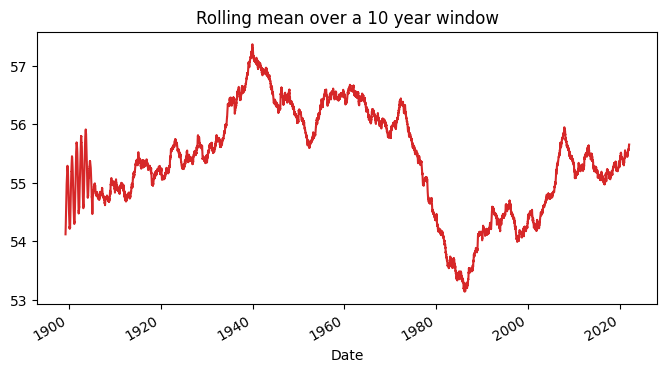

In [15]:
kc_temps["Tavg"].rolling(window = 365*10).mean().plot(figsize=(8,4), color="tab:red", title="Rolling mean over a 10 year window")
plt.show()

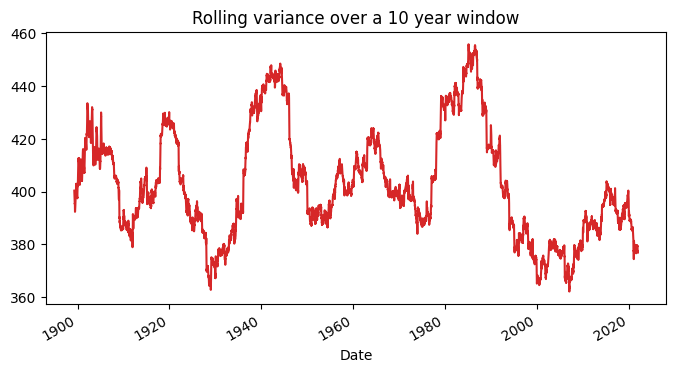

In [16]:
kc_temps["Tavg"].rolling(window = 365*10).var().plot(figsize=(8,4), color="tab:red", title="Rolling variance over a 10 year window")
plt.show()

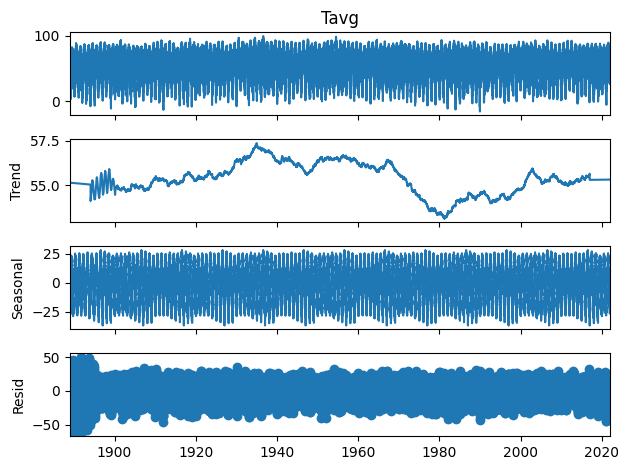

In [17]:
# seasonal decomposition
decompose_result = seasonal_decompose(kc_temps['Tavg'], model='additive', period=int(365*10), extrapolate_trend='freq')
 
trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid
 
decompose_result.plot()
plt.show()

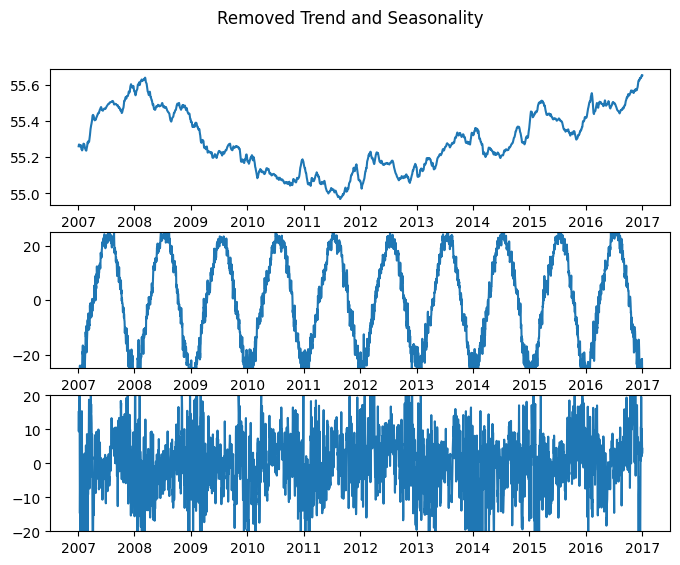

In [18]:
# visualize 10 years
years_examine = 365*5
start_date = 3*years_examine
fig, axs = plt.subplots(3, figsize=(8,6))
fig.suptitle('Removed Trend and Seasonality')
axs[0].plot(trend[-start_date:-years_examine])
axs[1].plot(seasonal[-start_date:-years_examine])
axs[1].set_ylim([-25,25])
axs[2].plot(residual[-start_date:-years_examine])
axs[2].set_ylim([-20,20])
plt.show()

<Axes: >

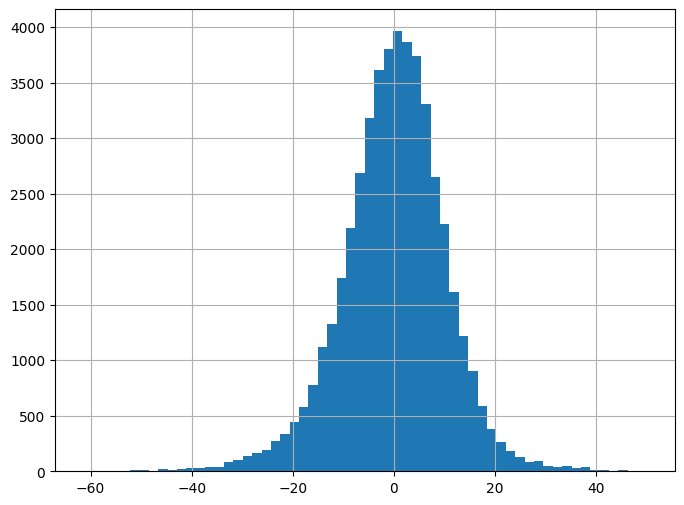

In [19]:
# check residual distribution
residual.hist(bins=60, figsize=(8,6))